In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import torch

from datasets.mnist import MNIST
from datasets.fashion_mnist import FashionMNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem3 import ContrastiveExplanationMethod

# set random seeds for reproducability (although the CEM is fully determininstic)
torch.manual_seed(0)
np.random.seed(0)

In [9]:
# dataset = MNIST(batch_size=64)
dataset = FashionMNIST(batch_size=64, download=True)
device = 'cuda:0'

2.4%

100.0%

Extracting ./datasets/data/fashion_mnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets/data/fashion_mnist\FashionMNIST\raw


83.3%

0.0%0%

Extracting ./datasets/data/fashion_mnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/data/fashion_mnist\FashionMNIST\raw


159.1%

Extracting ./datasets/data/fashion_mnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/data/fashion_mnist\FashionMNIST\raw
Extracting ./datasets/data/fashion_mnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/data/fashion_mnist\FashionMNIST\raw
Processing...
Done!


# Training the classifier

In [11]:
cnn = CNN(device=device)

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='fashion-mnist-cnn', device=device, load_path="")

D:\Programmeren\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


loss after step 0:2.303133010864258 accuracy: 0.109375
loss after step 100:2.3030948638916016 accuracy: 0.0625
loss after step 200:2.3022849559783936 accuracy: 0.109375
loss after step 300:2.3025858402252197 accuracy: 0.109375
loss after step 400:2.302536725997925 accuracy: 0.078125
loss after step 500:2.303011894226074 accuracy: 0.078125
loss after step 600:2.303372383117676 accuracy: 0.078125
loss after step 700:2.3025825023651123 accuracy: 0.09375
loss after step 800:2.302993059158325 accuracy: 0.0625
loss after step 900:2.3024697303771973 accuracy: 0.078125
done with iteration: 0/20
loss after step 0:2.302260398864746 accuracy: 0.109375
loss after step 100:2.302121162414551 accuracy: 0.078125
loss after step 200:2.302408218383789 accuracy: 0.0625
loss after step 300:2.3023147583007812 accuracy: 0.0625
loss after step 400:2.300976276397705 accuracy: 0.140625
loss after step 500:2.3009259700775146 accuracy: 0.125
loss after step 600:2.3027307987213135 accuracy: 0.078125
loss after st

loss after step 900:1.7075507640838623 accuracy: 0.75
done with iteration: 13/20
loss after step 0:1.6454734802246094 accuracy: 0.828125
loss after step 100:1.7276890277862549 accuracy: 0.734375
loss after step 200:1.5689510107040405 accuracy: 0.90625
loss after step 300:1.6372038125991821 accuracy: 0.828125
loss after step 400:1.615563154220581 accuracy: 0.84375
loss after step 500:1.6943132877349854 accuracy: 0.78125
loss after step 600:1.6408222913742065 accuracy: 0.8125
loss after step 700:1.6871938705444336 accuracy: 0.78125
loss after step 800:1.603444218635559 accuracy: 0.875
loss after step 900:1.6565144062042236 accuracy: 0.8125
done with iteration: 14/20
loss after step 0:1.609177827835083 accuracy: 0.859375
loss after step 100:1.7006011009216309 accuracy: 0.765625
loss after step 200:1.611382246017456 accuracy: 0.859375
loss after step 300:1.6468982696533203 accuracy: 0.8125
loss after step 400:1.6145415306091309 accuracy: 0.859375
loss after step 500:1.6434910297393799 accu

In [21]:
images, label = dataset.get_batch()

output = cnn(images.cuda())

images = images.numpy()
output = output.cpu().detach().numpy()
print(output.argmax(1))
print(label)

[5 5 0 1 9 1 1 5 0 5 5 5 9 3 5 6 3 5 2 7 7 1 5 5 7 3 1 0 8 1 5 7 4 1 2 3 5
 9 8 2 3 0 9 4 2 5 7 5 4 3 5 8 1 5 1 7 1 2 0 5 2 5 5 7]
tensor([9, 7, 0, 3, 9, 1, 1, 5, 9, 7, 9, 7, 9, 0, 5, 6, 3, 7, 2, 7, 7, 1, 5, 5,
        7, 3, 1, 0, 3, 1, 7, 7, 4, 1, 0, 3, 5, 9, 8, 2, 3, 0, 9, 4, 2, 0, 7, 5,
        4, 3, 7, 8, 1, 5, 4, 7, 1, 2, 6, 9, 2, 3, 9, 9])


In [23]:
# evaluate the cnn by uncommenting this cell

total_acc = 0
total_batches = 0
for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):
    
    predictions = cnn(batch_inputs.cuda())
    acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0] )
    total_batches += 1
    total_acc += acc
    
print("acc: {}".format(total_acc / total_batches))

acc: 0.8400676751592356


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [24]:
# Train or load autoencoder
cae = CAE(device=device)

train_ae(cae, dataset, iterations=10, save_fn="fashion-mnist-cae", device=device, load_path="")

loss after epoch 0:0.008450109511613846
loss after epoch 1:0.00631324015557766
loss after epoch 2:0.005810833536088467
loss after epoch 3:0.005432640202343464
loss after epoch 4:0.0038359982427209616
loss after epoch 5:0.0050748917274177074
loss after epoch 6:0.004504803102463484
loss after epoch 7:0.005927060730755329
loss after epoch 8:0.003622033866122365
loss after epoch 9:0.0034544249065220356
Done training.


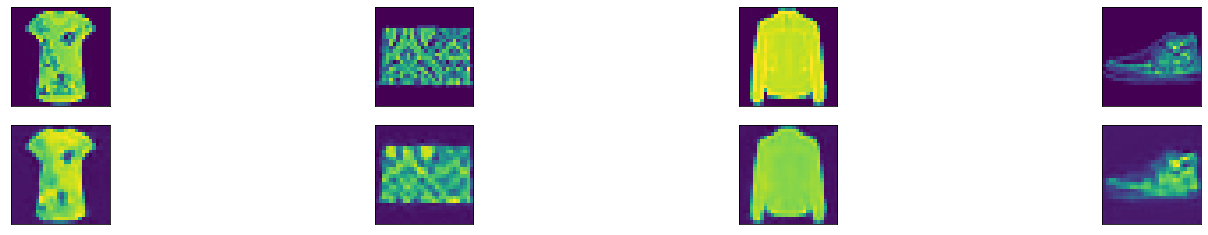

In [39]:
# obtain one batch of test images
images, _ = dataset.get_batch()

images += 1

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images.cuda())
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [12]:
# optimal: kappa 30, gamma 1.0, beta 0.1, lr 0.01

kappa = 30
gamma = 1.0
beta = 0.1
lr = 0.01
CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=1000,
    n_searches=9,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=10.0
)

In [13]:
def save_imgs():
    # save the created images
    dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
    os.makedirs(dirname, exist_ok=True)
    
    fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
    fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
    fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
    fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
    
    plt.imsave(fname_orig, image.squeeze(), cmap="gray")
    plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
    plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
    plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")

In [14]:
for i in range(10):
    # obtain one sample
    image = dataset.get_sample_by_class(class_label=i, show_image=False)

    print("IMAGE FROM CLASS: {}".format(i))
    before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
    
    for mode in ["PP", "PN"]:
        
        CEM.fista(image, mode=mode)
        
        if mode == "PP":
            after = after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
        else:
            after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
        
        save_imgs()

IMAGE FROM CLASS: 0
search: 0 iteration: 500 c: 10.0 loss: 326.42 found optimum: False
search: 0 iteration: 1000 c: 10.0 loss: 343.90 found optimum: False
new best: 120.96009063720703
new best: 100.87069702148438
new best: 94.95941925048828
new best: 91.664306640625
new best: 87.99156188964844
new best: 86.84324645996094
search: 1 iteration: 500 c: 100.0 loss: 202.08 found optimum: True
new best: 85.16813659667969
new best: 81.86997985839844
search: 1 iteration: 1000 c: 100.0 loss: 2553.09 found optimum: True
search: 2 iteration: 500 c: 50.05 loss: 96.09 found optimum: True
new best: 78.644775390625
search: 2 iteration: 1000 c: 50.05 loss: 1551.57 found optimum: True
new best: 77.70014953613281
new best: 77.35545349121094
new best: 77.2851791381836
search: 3 iteration: 500 c: 25.075 loss: 389.23 found optimum: True
search: 3 iteration: 1000 c: 25.075 loss: 798.47 found optimum: True
search: 4 iteration: 500 c: 12.5875 loss: 303.29 found optimum: True
search: 4 iteration: 1000 c: 12.587

new best: 75.34761047363281
search: 3 iteration: 500 c: 25.075 loss: 271.18 found optimum: True
search: 3 iteration: 1000 c: 25.075 loss: 796.98 found optimum: True
search: 4 iteration: 500 c: 12.5875 loss: 191.12 found optimum: False
search: 4 iteration: 1000 c: 12.5875 loss: 421.18 found optimum: False
search: 5 iteration: 500 c: 125.875 loss: 2056.10 found optimum: True
search: 5 iteration: 1000 c: 125.875 loss: 1592.24 found optimum: True
search: 6 iteration: 500 c: 62.9875 loss: 779.96 found optimum: True
search: 6 iteration: 1000 c: 62.9875 loss: 1498.58 found optimum: True
new best: 75.18296813964844
search: 7 iteration: 500 c: 31.54375 loss: 285.61 found optimum: True
search: 7 iteration: 1000 c: 31.54375 loss: 991.65 found optimum: True
search: 8 iteration: 500 c: 15.821875 loss: 170.25 found optimum: False
search: 8 iteration: 1000 c: 15.821875 loss: 518.51 found optimum: False
search: 0 iteration: 500 c: 10.0 loss: 302.58 found optimum: False
search: 0 iteration: 1000 c: 10.

search: 2 iteration: 500 c: 50.05 loss: 281.28 found optimum: False
search: 2 iteration: 1000 c: 50.05 loss: 1573.86 found optimum: False
new best: 99.11260986328125
new best: 92.6505126953125
search: 3 iteration: 500 c: 500.5 loss: 136.08 found optimum: True
new best: 92.39713287353516
new best: 90.90373992919922
new best: 89.14472198486328
new best: 88.56207275390625
new best: 86.82327270507812
new best: 86.72612762451172
new best: 85.37324523925781
new best: 84.75202941894531
new best: 83.95320129394531
new best: 82.92184448242188
new best: 82.72726440429688
new best: 80.97838592529297
new best: 80.11632537841797
new best: 78.40177154541016
new best: 77.38555145263672
new best: 75.80413818359375
new best: 74.93317413330078
new best: 73.11981964111328
new best: 71.93565368652344
new best: 70.16256713867188
new best: 69.94031524658203
new best: 68.70464324951172
new best: 68.49854278564453
new best: 66.71379089355469
new best: 64.89114379882812
new best: 62.8815803527832
new best: 61.

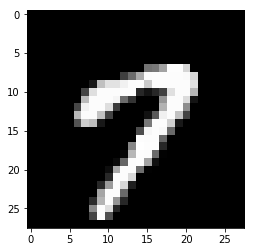

classification before perturbation: 7


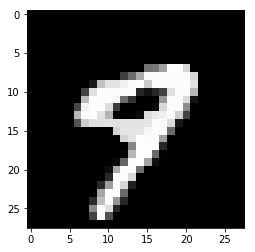

classification after perturbation: 9


In [59]:
# print original image
plt.imshow(image.view(28,28), cmap="gray")
plt.show()

# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
print("classification before perturbation: {}".format(before))

if mode == "PP":
    plt.imshow(image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")
    plt.show()
    after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification of delta: {}".format(after))
else:
    plt.imshow(CEM.best_delta.view(28,28),  cmap="gray")
    plt.show()
    after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification after perturbation: {}".format(after))